# Estimating molecular volumes to aid in powder X-ray diffraction indexing
> An overview of using database-derived atomic volumes to aid PXRD indexing.

- toc: true
- badges: false
- comments: true
- categories: [PXRD, Indexing]
- author: Mark Spillman
- image: images/Volumes.png

# Introduction

An [article](http://scripts.iucr.org/cgi-bin/paper?S0108768101021814) published in 2001 by D. W. M. Hofmann describes how crystallographic databases can be used to derive the average volume occupied by atoms of each element in crystal structures. Using his tabulated values, it's possible to rapidly estimate the volume occupied by a given molecule, and use this to aid indexing of powder diffraction data. This is particularly useful for laboratory diffraction data, which is generally associated with lower figures of merit such as de Wolff's $M_{20}$ and Smith and Snyder's $F_N$, which can make discriminating between alternative options more challenging. Other volume estimation methods, notably the 18 Å³ rule are also commonly used, though Hofmann's volumes give generally more accurate results.

I've put together a freely available web-app, *HofCalc*, which can be used to conveniently obtain these estimates. It should display reasonably well on mobile devices as well as PCs/laptops. You can access it at the following address:

[https://hofcalc.herokuapp.com](https://hofcalc.herokuapp.com)

![](images/HofCalc.png)

This post will explain how it works, and will look at some examples of how it can be used in practice. I'm grateful to Norman Shankland who provided invaluable feedback and assistance with debugging of the app.

# Hofmann volumes

After applying various filters to crystal structures deposited in the CSD, Hofmann ended up with a dataset comprised of 182239 structures. Hofmann only considers the elements up to atomic number 100 (fermium) in his work, and assumes that the volume of the unit cell is equivalent to:

$$V_{est} = \sum\limits_{i=1}^{100} n_i\bar{v_i}(1+\bar{\alpha}T) = \bold{n\bar{v}}(1+\bar{\alpha}T)$$

Where $n_i$ is the number of atoms of element $i$ in the unit cell, and $\bar{v_i}$ is the average volume occupied by an atom of element $i$. He also assumes that atomic volumes vary linearly with temperature.

He split the dataset into 20 subsets, then used an iterative least-squares method to solve the above equation for each of the subsets. This allowed him to find the average volumes occupied by atoms of each element, and due to the splitting of the data into subsets, he also obtains their standard deviations. The coefficient of thermal expansion, $\bar{\alpha}$, was found to be $0.95 \times 10^{-4} K^{-1}$. This temperature correction factor then allowed him to provide the average volumes for all of the elements represented in the CSD at 298 K.

You can download a ```.json``` file containing the 298 K volumes [here](https://github.com/mspillman/blog/blob/master/_notebooks/files/Hofmann-volumes.json).

# Comparison with other atomic volumes

Let's compare Hofmann's volumes to those obtained from other sources. Hofmann's article compares his volumes to those derived by Mighell and coworkers, which were published in 1987. As additional comparison points, which highlight the importance of using *crystallographic volumes* in this context, I also downloaded some [atomic radii data](https://en.wikipedia.org/wiki/Atomic_radii_of_the_elements_%28data_page%29) from Wikipedia and converted these into atomic volumes (assuming spherical atoms). Sources for these radii may be found at the bottom of the Wikipedia article.

Click on the coloured boxes in the top left to view individual types of volume, and shift-click to add other volumes back in again.

In [51]:
#collapse-hide
import json
import pandas as pd
import numpy as np
import altair as alt

with open("files/Hofmann-volumes.json") as hv:
    hofmann_volumes = json.load(hv)
hv.close()

vols = []
for i, key in enumerate(hofmann_volumes.keys()):
    vols.append([i+1, key, hofmann_volumes[key]])

df = pd.DataFrame(vols)
df.columns = ["Atomic number", "Element", "Hofmann"]
df.reset_index(drop=True, inplace=True)
df.replace("N/A", np.NaN, inplace=True)

wikiradii = pd.read_excel("files/wikipedia_radii.xlsx")
wikiradii.replace("", np.NaN, inplace=True)

radtype = ["Mighell", "Empirical","Calculated","vdW","Covalent-single","Covalent-triple",
        "Metallic"]
for r in radtype:
    # Radii are in pm so /100 to convert to angstroms.
    if r == "Mighell":
        df[r] = wikiradii[r].values.astype(float)
    else:
        df[r] = (4*np.pi/3)*(wikiradii[r].values.astype(float)/100)**3


# Convert our dataframe to long-form as this is what is expected by altair
dflong = df.melt("Atomic number", var_name="Volume",
                value_vars=["Hofmann"] + radtype)

# Restore the element symbols to the long dataframe
element = []
for an in dflong["Atomic number"]:
    element.append(df["Element"][df["Atomic number"] == an].item())
dflong["Element"] = element

# Select tool modifies opacity of plotted points
"""selection = alt.selection_single(
    name='Select type of',
    fields=['Volume'],
    init={'Volume': "Hofmann"},
    bind={'Volume': alt.binding_select(options=["Hofmann"] + radtype)}
)"""

click = alt.selection_multi(encodings=["color"])

# scatter plot, modify opacity based on selection
scatter = alt.Chart(dflong).mark_point().encode(
    x=alt.X('Element:N',sort=dflong["Atomic number"].values),
    y=alt.Y("value:Q", axis=alt.Axis(title='Volume / Å³')),
    tooltip=['Element', 'Volume:N', 'value'],
    #opacity=alt.condition(selection, alt.value(1.0), alt.value(.1)),
    color="Volume:N"
).transform_filter(click).properties(width=650, height=500).interactive()

# legend
legend = alt.Chart(dflong).mark_rect().encode(
    y=alt.Y('Volume:N', axis=alt.Axis(title='Select volume'), sort=[4,6,0,1,2,3,5,7]),
    color=alt.condition(click, 'Volume:N',
                        alt.value('lightgray'), legend=None),
).properties(
    selection=click,
)

chart = (legend | scatter)


chart

alt.HConcatChart(...)

As you can see, the volumes of Hofmann and Mighell differ significantly from those I derived from the atomic radii.

Let's print out some of the statistics describing the data, as well compare the coefficient of variation for each type of volume.

In [50]:
#collapse-hide
df.describe()[["Hofmann"]+radtype]

,Hofmann,Mighell,Empirical,Calculated,vdW,Covalent-single,Covalent-triple,Metallic
count,84.000000,100.00000,91.000000,86.000000,55.000000,95.000000,71.000000,68.000000
mean,39.586310,42.65840,17.084519,23.849111,37.865054,13.250696,6.963913,19.946436
std,13.460829,17.12722,12.248898,20.652779,33.870162,8.900926,3.301590,12.541749
min,5.080000,5.40000,0.065450,0.124788,7.238229,0.137258,0.623615,5.884949
25%,31.000000,30.87500,10.305995,7.377367,19.870146,7.329463,4.988916,11.039115
50%,39.300000,41.00000,12.770051,19.334951,27.833137,11.008442,6.538266,17.157285
75%,49.250000,53.50000,23.632685,36.484963,39.070796,19.160766,9.204406,24.469830
max,74.000000,85.00000,77.951815,110.850435,176.533179,52.306127,16.837592,77.951815


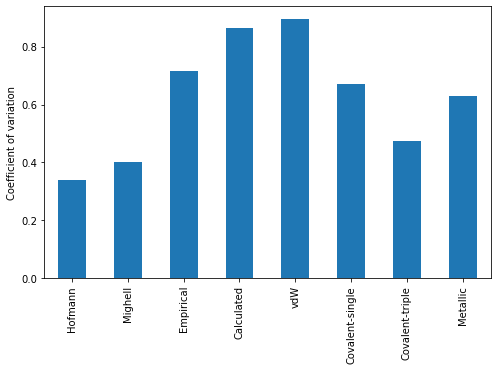

In [11]:
#collapse-hide
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
((df.describe().loc["std"] / df.describe().loc["mean"])[["Hofmann"]+radtype]).plot.bar()
plt.ylabel("Coefficient of variation")
plt.show()

We see a much lower coefficient of variation for Hofmann's volumes than the others.

# HofCalc - using the web app

[HofCalc](http://hofcalc.herokuapp.com) makes use of two key python libraries to process chemical formulae ([pyvalem](https://github.com/xnx/pyvalem)) and resolve chemical names ([PubChemPy](https://github.com/mcs07/PubChemPy)) prior to processing. This allows the app to have a really convenient interface for specifying queries (see below), which enables users to easily mix and match between formulae and names to obtain the information they need.

## Formulae and names

### Basic use
The simplest option is to enter the chemical formula or name of the material of interest. Names are resolved by querying [PubChem](https://pubchem.ncbi.nlm.nih.gov/), so common abbreviations for solvents can often be used e.g. DMF.
Note that formulae can be prefixed with a multiple, e.g. 2H2O

| Search term |   Type  | $V_{Hofmann}$ |
|:-----------:|:-------:|:-------------:|
| ethanol     | name    | 69.61         |
| CH3CH2OH    | formula | 69.61         |
| water       | name    | 21.55         |
| 2H2O        | formula | 43.10         |


### Multiple search terms

It is also possible to search for multiple items simultaneously, and mix and match name and formulae by separating individual components with a semicolon. This means that for example, 'amodiaquine dihydrochloride dihydrate' can also be entered as 'amodiaquine; 2HCl; 2H2O'.

|              Search term              | Total $V_{Hofmann}$ |
|:-------------------------------------:|:-------------------:|
| carbamazepine; L-glutamic acid        | 497.98              |
| zopiclone; 2H2O                       | 496.02              |
| C15H12N2O; CH3CH2COO-; Na+            | 419.79              |
| sodium salicylate; water              | 204.21              |
| amodiaquine dihydrochloride dihydrate | 566.61              |
| amodiaquine; 2HCl; 2H2O               | 566.61              |


### More complex examples - hemihydrates

In cases where fractional multiples of search components are required, such as with hemihydrates, care should be taken to check the evaluated chemical formula for consistency with the expected formula.

|                                    Search term              |     Evaluated as     | $V_{Hofmann}$     | Divide by | Expected Volume |
|:-----------------------------------------------------------:|:--------------------:|:-----------------:|:---------:|:---------------:|
| Calcium sulfate hemihydrate                                 | Ca2 H2 O9 S2         | 253.07            | 2         | 126.53          |
| calcium; calcium; sulfate; sulfate; water                   | Ca2 H2 O9 S2         | 253.07            | 2         | 126.53          |
| calcium; sulfate; 0.5H2O                                    | Ca1 H1.0 O4.5 S1     | 126.53            | -         | 126.53          |
| Codeine phosphate hemihydrate                               | C36 H50 N2 O15 P2    | 1006.77           | 2         | 503.38          |
| codeine; codeine; phosphoric acid; phosphoric acid; water   | C36 H50 N2 O15 P2    | 1006.77           | 2         | 503.38          |
| codeine; phosphoric acid; 0.5H2O                            | C18 H25.0 N1 O7.5 P1 | 503.38            | -         | 503.38          |

### Charged species in formulae

Charges could potentially interfere with the parsing of chemical formulae. For example, two ways of representing an oxide ion:

| Search term | Evaluated as |
|:-----------:|:------------:|
| O-2         | 1 x O        |
| O2-         | 2 x O        |

Whilst is is recommended that charges be omitted from HofCalc queries, if including charges in your queries, ensure that the correct number of atoms has been determined in the displayed atom counts or the downloadable summary file. For more information on formatting formulae, see the [pyvalem documentation](https://github.com/xnx/pyvalem).


## Temperature

The temperature, $T$ (in kelvin) is automatically included in the volume calculation via the following equation:

$$V = \sum{n_{i}v_{i}}(1 +  \alpha(T - 298))$$

Where $n_{i}$ and $v_{i}$ are the number and Hofmann volume (at 298 K) of the $i$th element in the chemical formula, and $\alpha = 0.95 \times 10^{-4} K^{-1}$.


## Unit cell volume

If the volume of a unit cell is supplied, then the unit cell volume divided by the estimated molecular volume will also be shown.

|   Search term   | $V_{cell}$       | $V_{Hofmann}$  | $\frac{V_{cell}}{V_{Hofmann}}$ |
|:---------------:|:----------------:|:--------------:|:------------------------------:|
| zopiclone, 2H2O | 1874.61          | 496.02         | 3.78                           |
| verapamil, HCl  | 1382.06          | 667.57         | 2.07                           |


## Summary Files

Each time HofCalc is used, a downloadable summary file is produced. It is designed to serve both as a record of the query for future reference and also as a method to sense-check the interpretation of the entered terms, with links to the PubChem entries where relevant.
An example of the contents of the summary file for the following search terms is given below.

Search term = ```carbamazepine; indomethacin```

T = 293 K

Unit cell volume = 2921.6 Å³


```json
{
    "combined": {
        "C": 34,
        "H": 28,
        "N": 3,
        "O": 5,
        "Cl": 1
    },
    "individual": {
        "carbamazepine": {
            "C": 15,
            "H": 12,
            "N": 2,
            "O": 1
        },
        "indomethacin": {
            "C": 19,
            "H": 16,
            "Cl": 1,
            "N": 1,
            "O": 4
        }
    },
    "user_input": [
        "carbamazepine",
        "indomethacin"
    ],
    "PubChem CIDs": {
        "carbamazepine": 2554,
        "indomethacin": 3715
    },
    "PubChem URLs": {
        "carbamazepine": "https://pubchem.ncbi.nlm.nih.gov/compound/2554",
        "indomethacin": "https://pubchem.ncbi.nlm.nih.gov/compound/3715"
    },
    "individual_volumes": {
        "carbamazepine": 303.86,
        "indomethacin": 427.77
    },
    "V_Cell / V_Hofmann": 3.99,
    "Temperature": 293,
    "Hofmann Volume": 731.62,
    "Hofmann Density": 1.35
}
```

# Case study: CT-DMF2

The crystal structure of chlorothiazide N,N-dimethylformamide, a.k.a [CT-DMF2](https://doi.org/10.1002/jps.20942), was solved from laboratory powder diffraction data back in 2007. I decided to try re-indexing the diffraction data to see if HofCalc would be of use.

Using the *DASH* interface to *DICVOL*, the following unit cells are suggested:

![](images/DASH-indexing.png)

Both monoclinic and triclinic cells are obtained with very different unit cell volumes. Whilst the figures of merit certainly push towards accepting the conclusion of a monoclinic unit cell, it's worth checking to see if this makes sense given the expected composition of the material. In addition, there may be more than one dimethylformamide molecule crystallising with the chlorothiazide - HofCalc may be able to shed some light there too.

The [paper](https://doi.org/10.1002/jps.20942) states that the solvate was formed by recrystallisation of chlorothiazide from DMF solvent, so it seems logical to try the following permutations:
1. chlorothiazide alone
2. chlorothiazide + 1 DMF
3. chlorothiazide + 2 DMF (etc)


| HofCalc query                   | $V_{Hofmann}$ | $V_{cell}$         | $\frac{V_{cell}}{V_{Hofmann}}$ |
|:-------------------------------:|:-------------:|:------------------:|:------------------------------:|
| chlorothiazide                  | 284.73        | 2422 (triclinic)   | 8.51                           |
| chlorothiazide                  | 284.73        | 3950 (monoclinic)  | 13.87                          |
| chlorothiazide; DMF             | 385.09        | 2422 (triclinic)   | 6.29                           |
| chlorothiazide; DMF             | 385.09        | 3950 (monoclinic)  | 10.26                          |
| chlorothiazide; DMF; DMF        | 485.45        | 2422 (triclinic)   | 4.99                           |
| chlorothiazide; DMF; DMF        | 485.45        | 3950 (monoclinic)  | 8.14                           |
| chlorothiazide; DMF; DMF; DMF   | 585.81        | 2422 (triclinic)   | 4.13                           |
| chlorothiazide; DMF; DMF; DMF   | 585.81        | 3950 (monoclinic)  | 6.74                           |

If we exclude those results with $\frac{V_{cell}}{V_{mol}}$ ratios > 0.25 away from a (crystallographically sensible) whole number, we can see from the table that the most favourable compositions are CT + 2xDMF (monoclinic) and CT + 3xDMF (triclinic). Given the higher figure of merit for the monoclinic unit cell, it seems reasonable to take this forward and attempt space-group determination. Doing this in *DASH* identifies the most probable space group as $P2_1/c$, which then implies $Z'=2$. This is indeed the correct result.

If we compare this to the commonly used 18 Å³ rule, we end up with the following results:

| Possible composition            | $V_{18Å^{3}}$     | $V_{cell}$         | $\frac{V_{cell}}{V_{18Å^{3}}}$ |
|:-------------------------------:|:-------------:|:------------------:|:--------------------------:|
| chlorothiazide                  | 306           | 2422 (triclinic)   | 7.92                       |
| chlorothiazide                  | 306           | 3950 (monoclinic)  | 12.91                      |
| chlorothiazide; DMF             | 396           | 2422 (triclinic)   | 6.12                       |
| chlorothiazide; DMF             | 396           | 3950 (monoclinic)  | 9.97                       |
| chlorothiazide; DMF; DMF        | 486           | 2422 (triclinic)   | 4.98                       |
| chlorothiazide; DMF; DMF        | 486           | 3950 (monoclinic)  | 8.13                       |
| chlorothiazide; DMF; DMF; DMF   | 576           | 2422 (triclinic)   | 4.20                       |
| chlorothiazide; DMF; DMF; DMF   | 576           | 3950 (monoclinic)  | 6.86                       |

Again, CT + 2xDMF is in the candidates to check, however, using the 18 Å³ rule, a triclinic pure chlorothiazide unit cell also becomes a viable possibility. Had there been a less clear distinction in the indexing figure-of-merit, this may have resulted in time being wasted on testing this additional possibility.

# Conclusions

Hofmann's volumes give more accurate estimates of molecular volumes in crystals, and should be used in preference to the 18 Å³ rule where possible.

To make this easier for people, the [HofCalc web-app](https://hofcalc.herokuapp.com) can be used to very rapidly and conveniently obtain these estimates.